In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit,fsolve
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['errorbar.capsize'] = 6
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

enss=['b','c','d','e']
enss=['b']
ens2full={'a24':'cA211.53.24','a':'cA2.09.48','b':'cB211.072.64','c':'cC211.060.80','d':'cD211.054.96','e':'cE211.044.112'}
ens2label={'a24':'A24','a':'A48','b':'B64','c':'C80','d':'D96','e':'E112'}
ens2a={'a24':0.0908,'a':0.0938,'b':0.07957,'c':0.06821,'d':0.05692,'e':0.04892} # fm
ens2N={'a24':24,'a':48,'b':64,'c':80,'d':96,'e':112}
ens2N_T={'a24':24*2,'a':48*2,'b':64*2,'c':80*2,'d':96*2,'e':112*2}

ens2Z_1d_V={'b':1.1262,'c':1.1573,'d':1.1930,'e':1.2175}

# ens2mN={'a':931}
# ens2mpiC={'a':131}
# ens2mpi0={'a':111}

ens2amu={'a24':0.0053,'a':0.0009,'b':0.00072}
ens2amus={'b':0.0186}
ens2amuc={'b':0.249}
ens2ZP={'a24':(0.4670,0.0046),'a':(0.500,0.030)}

hbarc = 1/197.3
ens2aInv={ens:1/(ens2a[ens]*hbarc) for ens in enss} # MeV

ens2tfs={'b':range(2,22+1),'c':range(2,26+1),'d':range(2,30+1),'e':range(2,32+1)}

def fsolve2(func,x0):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res=fsolve(func, x0)[0]
    return res if res!=x0 else np.NaN



# ens='b'
# ens2a[ens]*hbarc*1000

def find_t_cloest(ens,t):
    return round(t/ens2a[ens])

In [2]:
data={}

stouts=range(6,11)
flas=[f'jg;stout{stout}' for stout in stouts] + ['j+','j-','js','jc']
for ens in enss:
    data[ens]={}
    tfs=ens2tfs[ens]

    path=f'/p/project1/ngff/li47/code/projectData/02_discNJN_1D/{ens2full[ens]}/data_earlytest/test2.h5'
    with h5py.File(path) as f:
        data[ens]['N0']=yu.jackknife(f['N_mom0'])
        data[ens]['N1']=yu.jackknife(f['N_mom1'])
        
        data[ens]['P44']={}
        data[ens]['P4i']={}
        data[ens]['P44_vev']={}
        for fla in flas:
            print(ens,fla,end='           \r')
            if ens=='e' and fla!='s':
                continue
                
            data[ens]['P44'][fla]={}
            data[ens]['P4i'][fla]={}
            for tf in tfs:
                data[ens]['P44'][fla][tf]=yu.jackknife(f[f'{fla}/P44(G0,0,0)/{tf}'][:])
                data[ens]['P4i'][fla][tf]=yu.jackknife(f[f'{fla}/P4i(G0,pi,pi)/{tf}'][:])
                
            data[ens]['P44_vev'][fla]=yu.jackknife(f[f'{fla}/P44(G0,0,0)_vev'])

# check with the paper

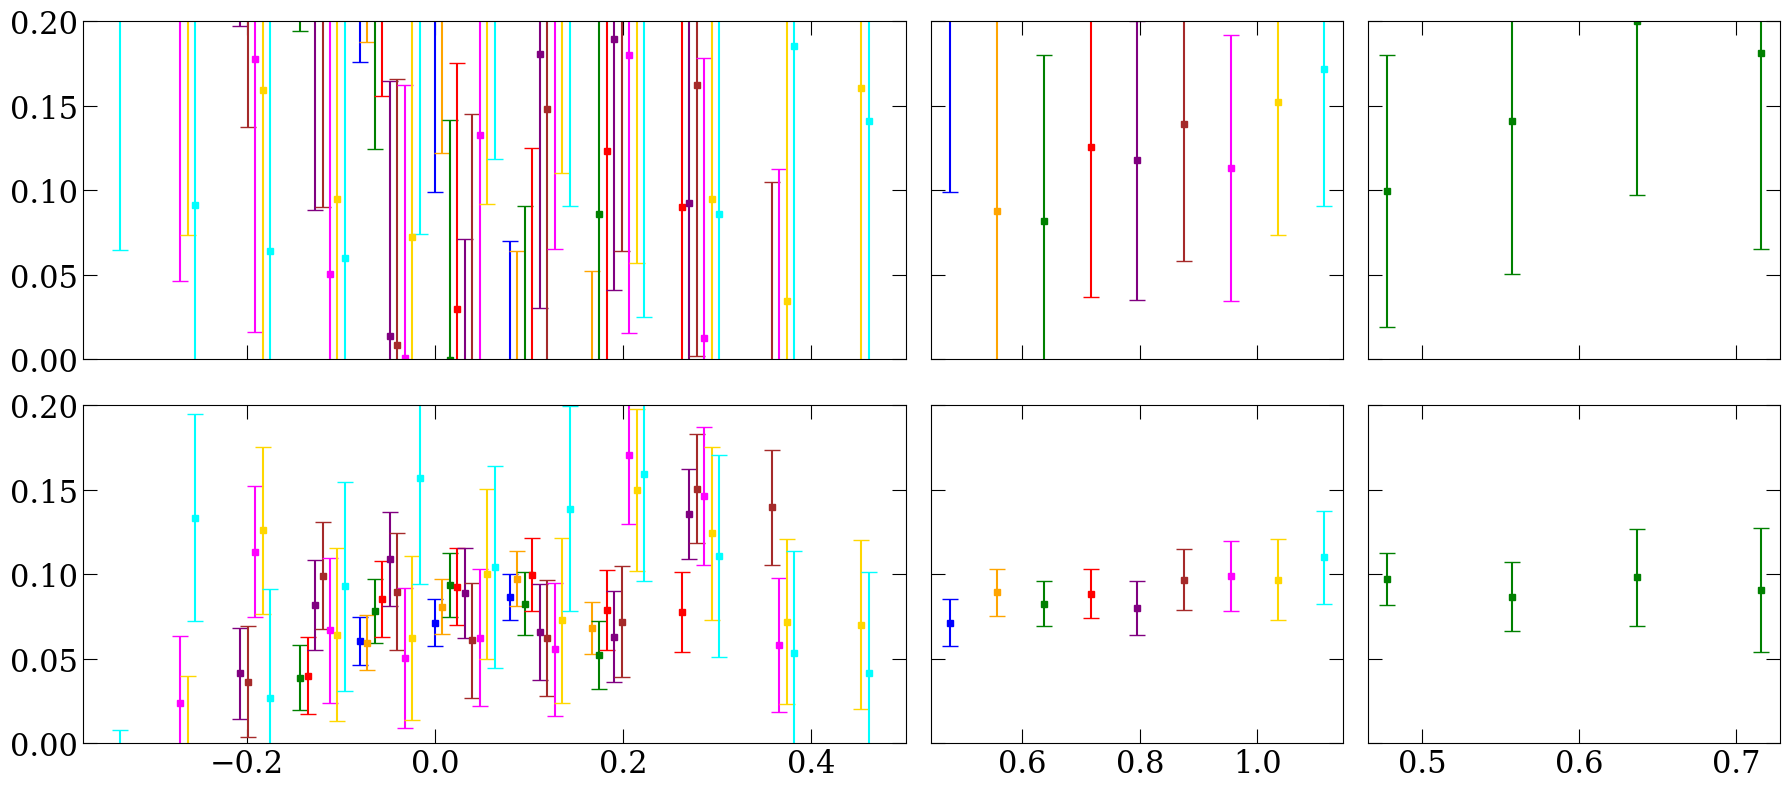

In [3]:
enss_plt=['b']

fix, axs = yu.getFigAxs(len(enss_plt)+1,3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [2, 1, 1]})
axs[0,0].set_ylim([0,0.2])

j='j+'
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=1
    tfs=ens2tfs[ens]
    tfs_plt=range(6,14+1,1)
    tfs_fit=tfs_plt
    
    cN0=np.real(data[ens]['N0'])
    cN1=np.real(data[ens]['N1'])
    
    amN=938/ens2aInv[ens]
    
    c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
    vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
    ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
    
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}
    
    for iratio,ratioDic in enumerate([ratioDic1,ratioDic2]):
        ax=axs[iratio,0]
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        t_cut=2
        for i_tf,tf in enumerate(tfs_plt):
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.1*(tf-6)+ (0.5 if tf%2!=0 else 0))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
            
        ax=axs[iratio,1]
        tcmin=3
        for i_tf,tf in enumerate(tfs_fit):
            ratio=ratioDic[tf]
            y_jk=ratio[:,tcmin:tf-tcmin+1]
            def fitfunc(pars):
                return list(pars)*(tf-2*tcmin+1)
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
            
            mean,err=yu.jackme(pars_jk)
            plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
            
        ax=axs[iratio,2]
        tfmins=[6,7,8,9]
        ratioSummedDic={tf:np.sum(ratioDic[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs}
        for tfmin in tfmins:
            y_jk=np.transpose([ratioSummedDic[tf] for tf in tfs_fit if tf>=tfmin])
            num=y_jk.shape[1]
            def fitfunc(pars):
                g,c=pars
                return g*np.arange(num)+c
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,1])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color='g')  
    
plt.tight_layout()

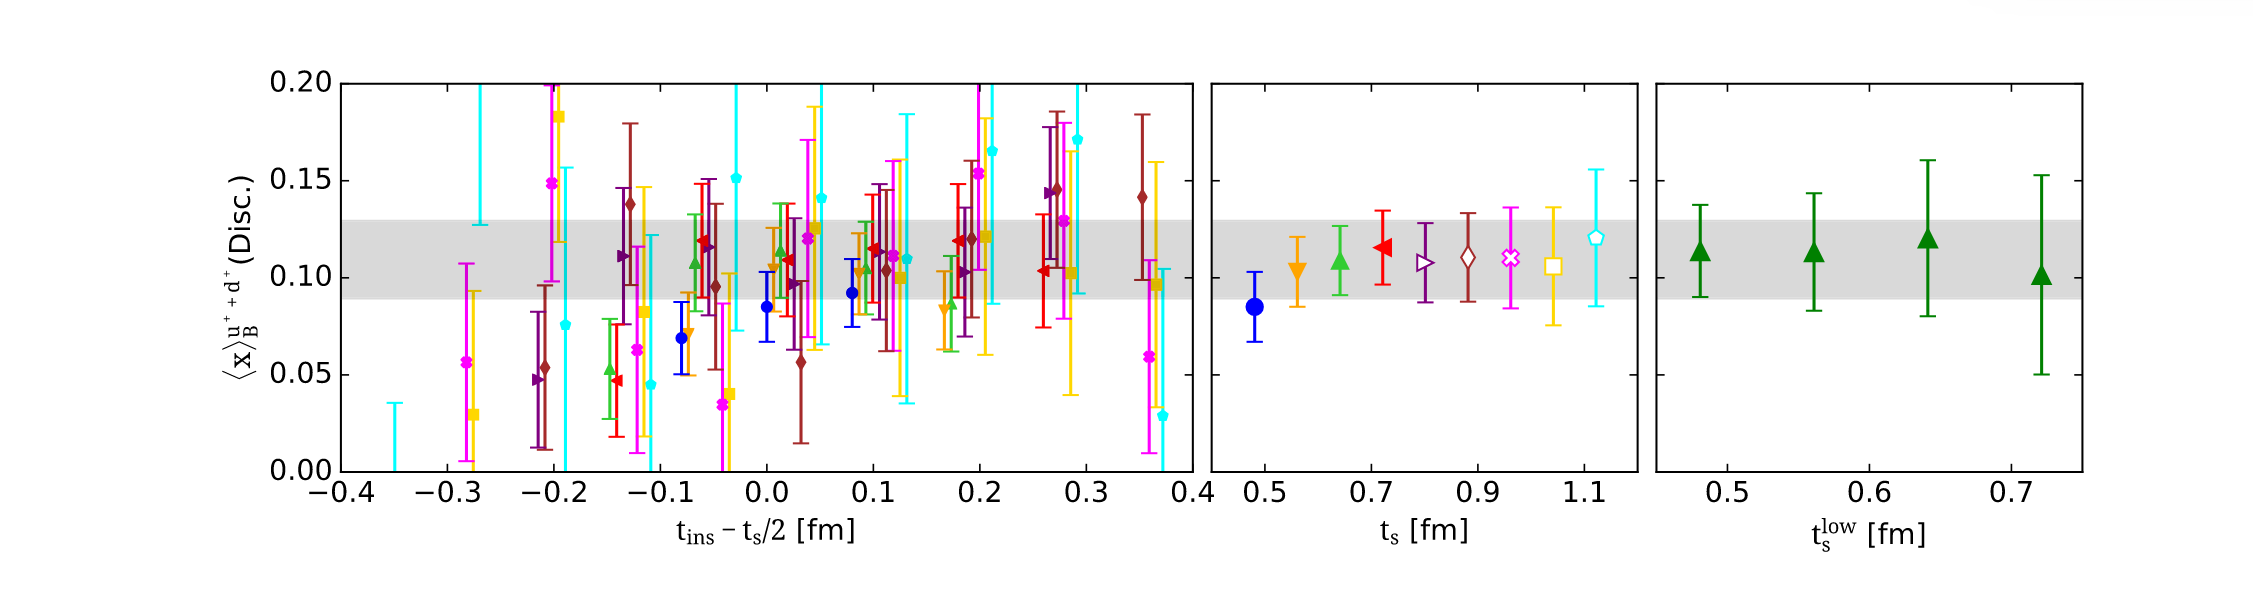

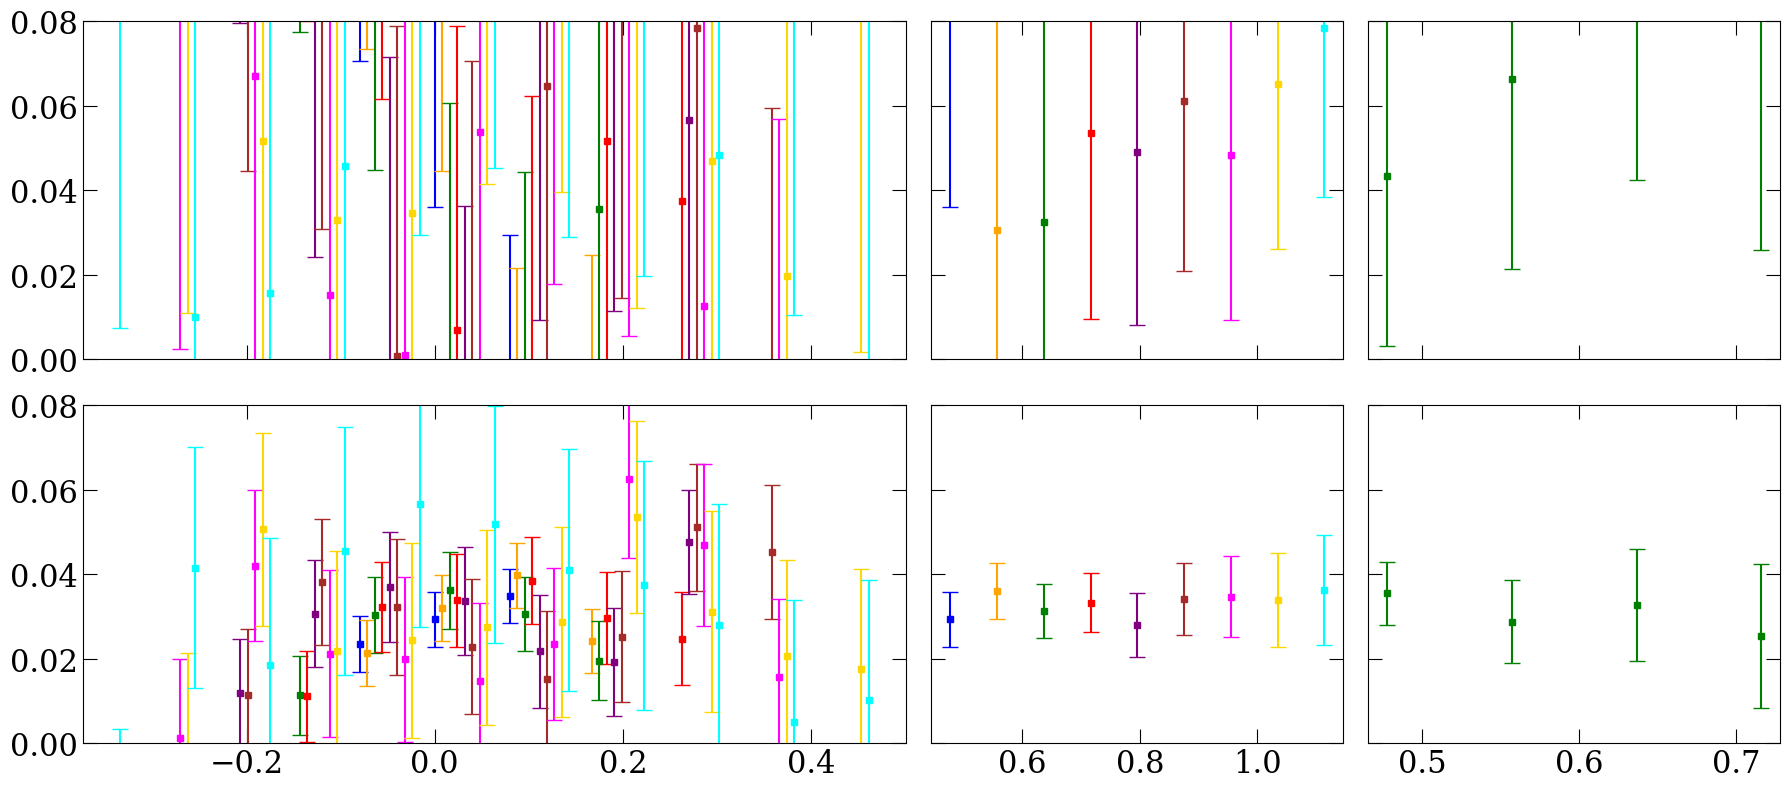

In [4]:
enss_plt=['b']

fix, axs = yu.getFigAxs(len(enss_plt)+1,3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [2, 1, 1]})
axs[0,0].set_ylim([0,0.08])

j='js'
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=1
    tfs=ens2tfs[ens]
    tfs_plt=range(6,14+1,1)
    tfs_fit=tfs_plt
    
    cN0=np.real(data[ens]['N0'])
    cN1=np.real(data[ens]['N1'])
    
    amN=938/ens2aInv[ens]
    
    c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
    vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
    ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
    
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}
    
    for iratio,ratioDic in enumerate([ratioDic1,ratioDic2]):
        ax=axs[iratio,0]
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        t_cut=2
        for i_tf,tf in enumerate(tfs_plt):
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.1*(tf-6)+ (0.5 if tf%2!=0 else 0))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
            
        ax=axs[iratio,1]
        tcmin=3
        for i_tf,tf in enumerate(tfs_fit):
            ratio=ratioDic[tf]
            y_jk=ratio[:,tcmin:tf-tcmin+1]
            def fitfunc(pars):
                return list(pars)*(tf-2*tcmin+1)
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
            
            mean,err=yu.jackme(pars_jk)
            plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
            
        ax=axs[iratio,2]
        tfmins=[6,7,8,9]
        ratioSummedDic={tf:np.sum(ratioDic[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs}
        for tfmin in tfmins:
            y_jk=np.transpose([ratioSummedDic[tf] for tf in tfs_fit if tf>=tfmin])
            num=y_jk.shape[1]
            def fitfunc(pars):
                g,c=pars
                return g*np.arange(num)+c
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,1])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color='g')  
    
plt.tight_layout()

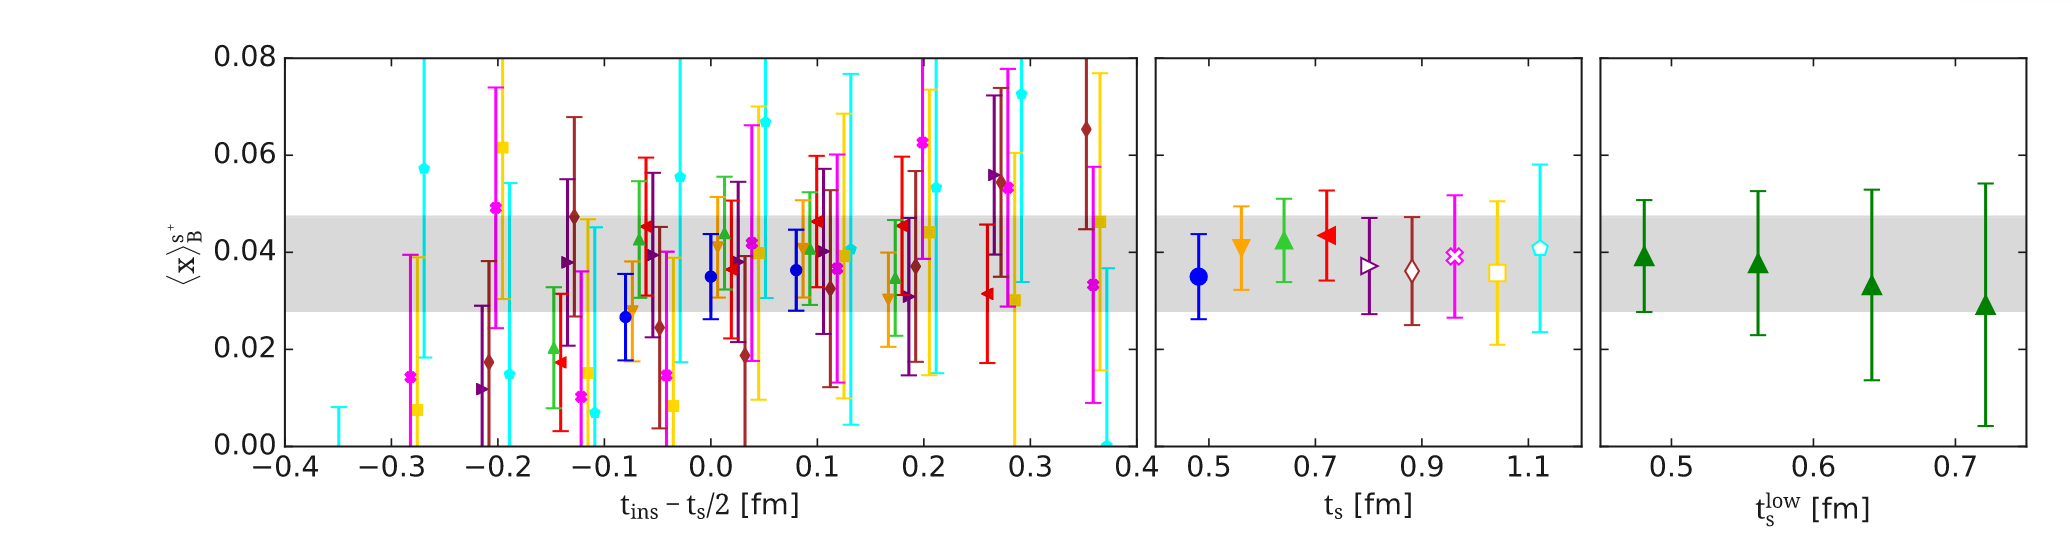

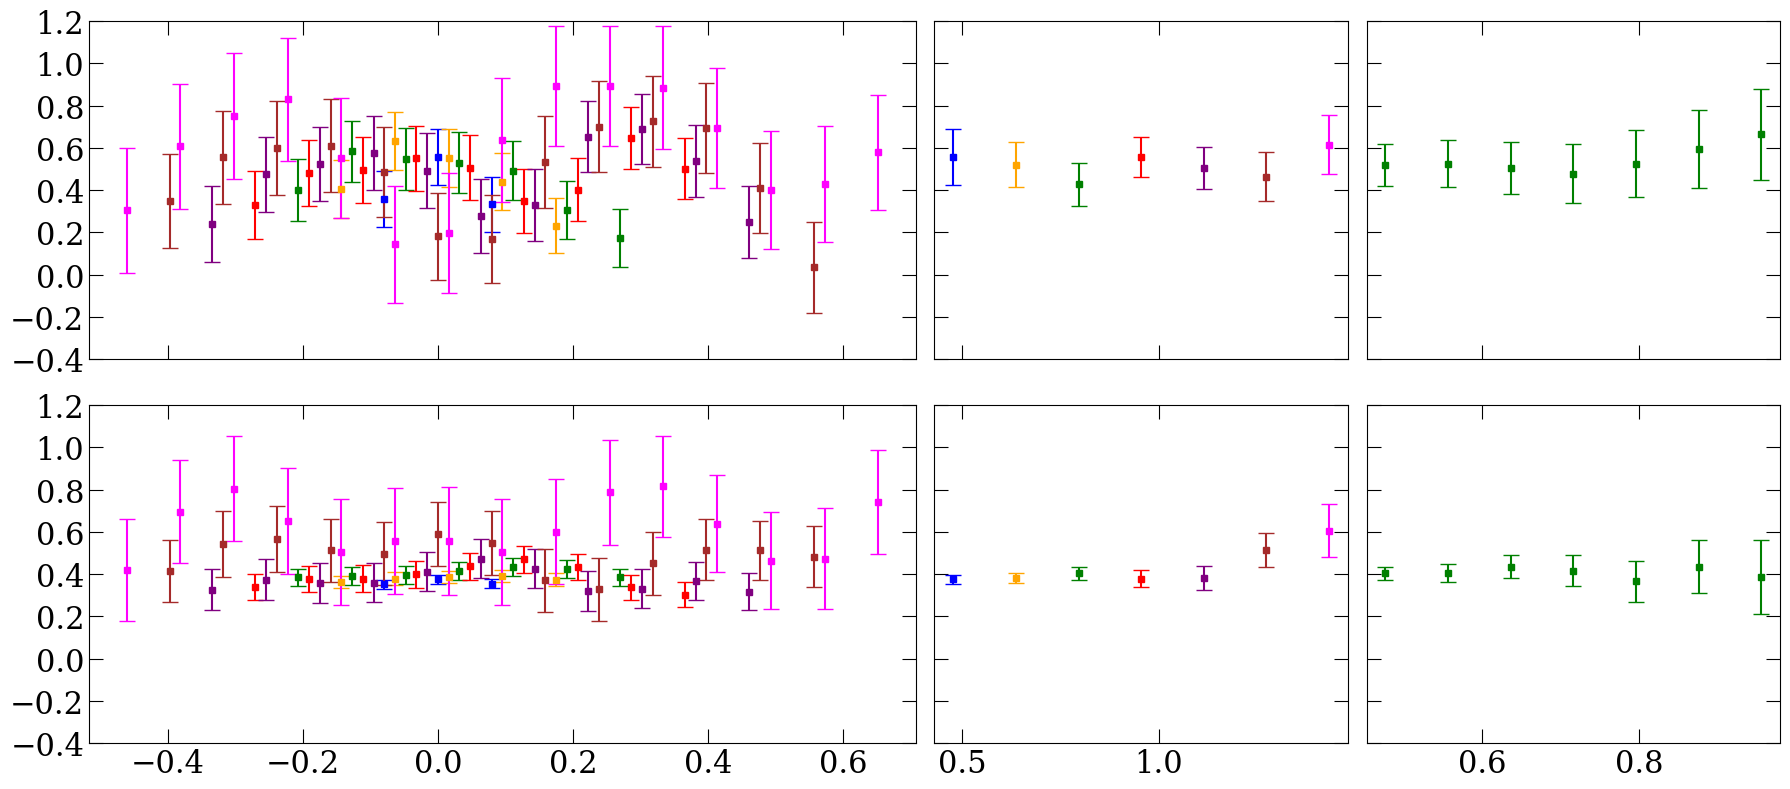

In [14]:
enss_plt=['b']

fix, axs = yu.getFigAxs(len(enss_plt)+1,3,Lrow=4,Lcol=6,sharex='col',sharey=True, gridspec_kw={'width_ratios': [2, 1, 1]})
axs[0,0].set_ylim([-0.4,1.2])
axs[0,0].set_yticks(np.arange(-0.4,1.3,0.2))

j='jg;stout10'
for i_ens,ens in enumerate(enss_plt):
    xunit=ens2a[ens]; yunit=1
    tfs=ens2tfs[ens]
    tfs_plt=range(6,18+1,2)
    tfs_fit=range(6,18+1,1)
    
    cN0=np.real(data[ens]['N0'])
    cN1=np.real(data[ens]['N1'])
    
    amN=938/ens2aInv[ens]
    
    c3ptDic={tf:np.real(data[ens]['P44'][j][tf]/(-3*amN/4)) for tf in tfs}
    vev=np.real(data[ens]['P44_vev'][j]/(-3*amN/4))
    ratioDic1={tf:(c3ptDic[tf]/cN0[:,tf:tf+1] - vev[:,None]) for tf in tfs}
    
    c3ptDic={tf:np.real(data[ens]['P4i'][j][tf]/(1j*2*np.pi/ens2N[ens])) for tf in tfs}
    ratioDic2={tf:c3ptDic[tf]/cN1[:,tf:tf+1] for tf in tfs}
    
    for iratio,ratioDic in enumerate([ratioDic1,ratioDic2]):
        ax=axs[iratio,0]
        colors=['b','orange','g','r','purple','brown','magenta','gold','cyan']
        t_cut=2
        for i_tf,tf in enumerate(tfs_plt):
            ratio=ratioDic[tf]
            mean,err=yu.jackme(ratio)
            tcs=np.arange(t_cut,tf-t_cut+1)
            plt_x=(tcs-tf/2+0.1*(tf-6)+ (0.5 if tf%2!=0 else 0))*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            # plt_x=(tcs-tf/2)*xunit; plt_y=mean[t_cut:tf+1-t_cut]*yunit; plt_yerr=err[t_cut:tf+1-t_cut]*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
            
        ax=axs[iratio,1]
        tcmin=3
        for i_tf,tf in enumerate(tfs_plt):
            ratio=ratioDic[tf]
            y_jk=ratio[:,tcmin:tf-tcmin+1]
            def fitfunc(pars):
                return list(pars)*(tf-2*tcmin+1)
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04])
            
            mean,err=yu.jackme(pars_jk)
            plt_x=tf*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i_tf])  
            
        ax=axs[iratio,2]
        tfmins=[6,7,8,9,10,11,12]
        ratioSummedDic={tf:np.sum(ratioDic[tf][:,tcmin:tf-tcmin+1],axis=1) for tf in tfs}
        for tfmin in tfmins:
            y_jk=np.transpose([ratioSummedDic[tf] for tf in tfs_fit if tf>=tfmin])
            num=y_jk.shape[1]
            def fitfunc(pars):
                g,c=pars
                return g*np.arange(num)+c
            pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,[0.04,1])
            
            mean,err=yu.jackme(pars_jk[:,0])
            plt_x=tfmin*xunit; plt_y=mean*yunit; plt_yerr=err*yunit
            ax.errorbar(plt_x,plt_y,plt_yerr,color='g')  
    
plt.tight_layout()

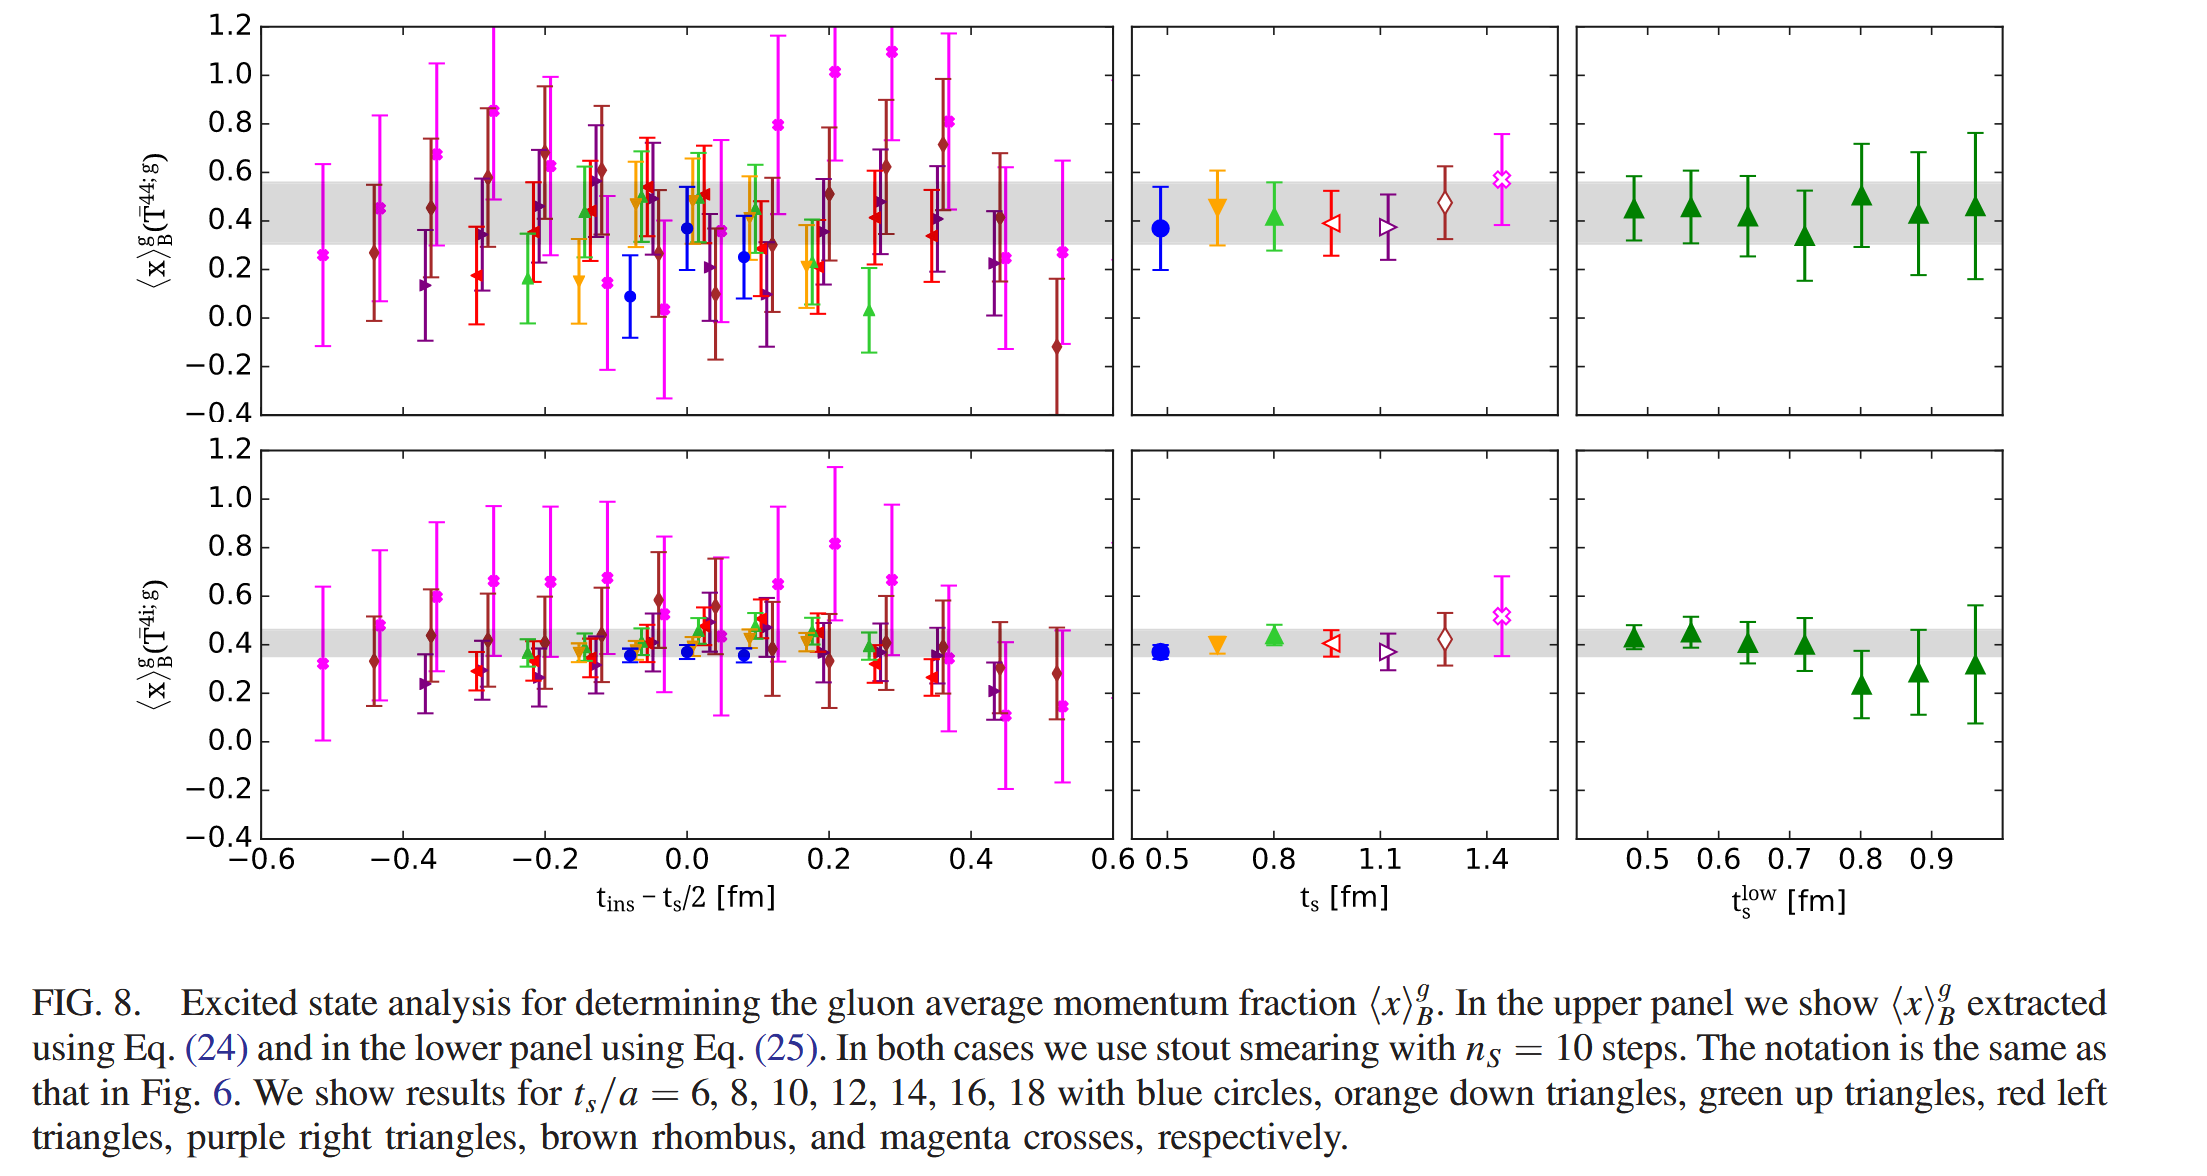